In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from typing import Tuple

# Stage 0. Data preparation

In [2]:
photos_num = 4
photos = [cv2.imread('test-images/' + name, cv2.COLOR_BGR2RGB) for name in [
    'mountain_1.jpg',
    'mountain_2.jpg',
    'mountain_3.jpg',
    'mountain_4.jpg'
]]

In [3]:
def show_image(image: np.ndarray, fig_size: Tuple[int, int] = (10, 5)) -> None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=fig_size)
    plt.imshow(image_rgb)
    plt.show()

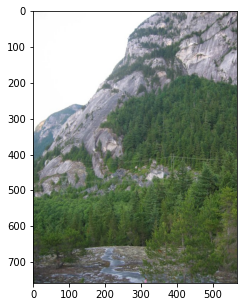

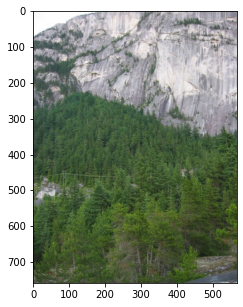

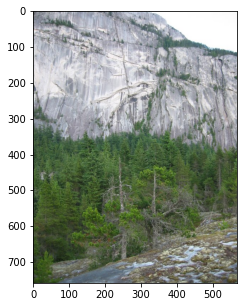

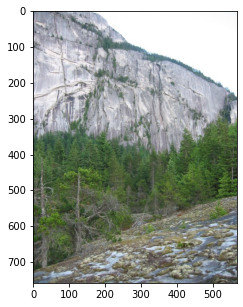

In [4]:
for photo in photos:
    show_image(photo)

# Stage 1. SIFT keypoints detection

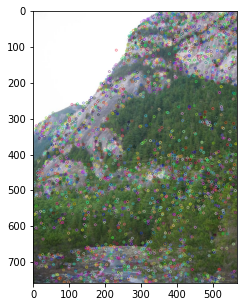

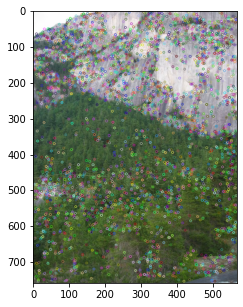

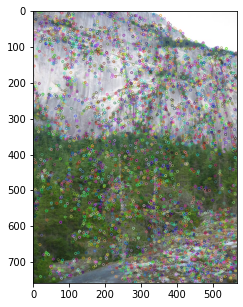

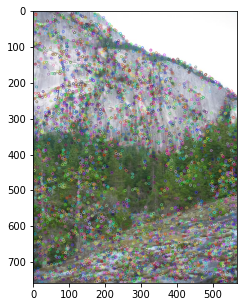

In [5]:
photos_grey = [cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY) for photo in photos]
sift = cv2.SIFT_create()
photos_sift_data = [sift.detectAndCompute(photo, None) for photo in photos_grey]
photos_with_keypoint = [np.empty_like(photo) for photo in photos]
for photo, photo_with_keypoint, (kps, des) in zip(photos, photos_with_keypoint, photos_sift_data):
    cv2.drawKeypoints(photo, kps, photo_with_keypoint)
    show_image(photo_with_keypoint)

# Stage 2. Image registrations

### Reference image selection

reference_img_idx:  2


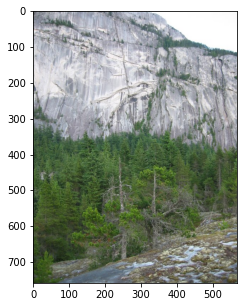

In [6]:
reference_img_idx = (photos_num - 0) // 2
print("reference_img_idx: ", reference_img_idx)
reference_img = photos[reference_img_idx]
reference_img_kps, reference_img_des = photos_sift_data[reference_img_idx]
show_image(reference_img)

In [7]:
def find_matches(matcher, des_src, des_dst):
    return np.array([
        m for m in matcher.knnMatch(des_src, des_dst, k=2)
        if m[0].distance < 0.5 * m[1].distance
    ])
def find_homography(matches: np.ndarray, kp_src: np.ndarray, kp_dst: np.ndarray,
                    from_right_side: bool = True, img_src_width: int = None) -> (np.ndarray, np.ndarray):
    """
    Finds homography thransformation matrix
    """
    src = np.float32([ kp_src[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp_dst[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    
    H, m = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)

    return H, m

### Image registrations implementation details
- for keypoints matching the brut force algorithm is used
- for finding a homography matrix the RANSAC algorithm is used
- below used 2 loops for searching homography from both sides of reference image in oposite direction for preventing calculating unnecessary inverses in the future

### L-M optmiization implemetatoin details:
- cost functoin is calculeted as weighted Eicledean distance between vectors in 2-dims space
- all the derivatives are computed using finite forward difference
- the step of L-M algorithm is calculated due to formula:
  $J^T J H_{step} = J^T e$, where $J$ - Jacobian matrix, $e$ - vector of residuals for chosen points and $H_{step}$ - optimization step for transormation matrix we're interested in

In [112]:
def cost(H: np.ndarray, pts1: np.ndarray, pts2: np.ndarray, s: float = 1.345) -> np.ndarray:
    r = np.linalg.norm((np.dot(H, pts1) - pts2)[:2, :], axis=0)
    mask = r < s
    r[mask] **= 2
    r[~mask] *= s
    return r
   
def compute_jacobian(H: np.ndarray, pts1: np.ndarray, pts2: np.ndarray, dHi: float = 1e-5, s: float = 1.345) -> (np.ndarray, np.ndarray):
    residuals = cost(H, pts1, pts2, s=s)

    dH = np.zeros((8, 3, 3))
    for i in range(8):
        dH[i, i // 3, i % 3] = dHi
    H_plus = H + dH

    J = np.array([cost(H_, pts1, pts2, s=s) for H_ in H_plus])
    J -= residuals
    J /= dHi
    return J.T, np.expand_dims(residuals, axis=1)

def LM_optmiization(H: np.ndarray, pts1: np.ndarray, pts2: np.ndarray, min_lr: float = 1e-5, steps: int = 100, s: float = 1.345) -> np.ndarray:
    H_k = H.copy()
    old_cost = cost(H, pts1, pts2).sum()

    lr = np.max(np.diag(H))
    for i in range(steps):
        
        J, residuals = compute_jacobian(H_k, pts1, pts2, s=s)
        A = np.dot(J.T, J)
        # the fastest way to add values to diagonal
        A.flat[::A.shape[0] + 1] += lr
        b = np.dot(J.T, residuals)
        
        H_step = np.linalg.solve(A, b)
        
        H_k.flat[:8] -= H_step.reshape(-1)
        
        # learning rate decay
        new_cost = cost(H_k, pts1, pts2).sum()
        lr *= (2 if new_cost >= old_cost else .5)
        old_cost = new_cost
        if lr < min_lr: break

    return H_k

# HELPER FUNCTIONS
def calc_LM_s_param(H: np.ndarray, pts1: np.ndarray, pts2: np.ndarray) -> float:
    return 1.345 * np.std(np.linalg.norm(np.dot(H, pts1) - pts2, axis=0))
rng = np.random.default_rng()
def random_choice_points(matches: np.ndarray, mask: np.ndarray, img_src_kps: np.ndarray, img_dst_kps: np.ndarray, size: int = 100) -> (np.ndarray, np.ndarray):
    sample = rng.choice(matches[(mask == 1).reshape(-1)], size, replace=False)[:, 0]
    pt1 = np.array([[*img_src_kps[sample[i].queryIdx].pt, 1] for i in range(size)])
    pt2 = np.array([[*img_dst_kps[sample[i].trainIdx].pt, 1] for i in range(size)])
    return pt1.T, pt2.T


In [114]:
def image_registration(apply_lm=False):
    bf_matcher = cv2.BFMatcher()
    featureList = [None] * photos_num
    maskList = [None] * photos_num
    HList = [None] * photos_num
    
    # searching homography from both sides of reference image in oposite direction
    # for preventing calculating unnecessary inverses in the future
    photos_idxs = [(i, i + 1) for i in range(reference_img_idx)] + [(i, i - 1) for i in range(reference_img_idx + 1, photos_num)]
    
    for src_i, dst_i in photos_idxs:
        kp_src, des_src = photos_sift_data[src_i]
        kp_dst, des_dst = photos_sift_data[dst_i]
        featureList[src_i] = find_matches(bf_matcher, des_src, des_dst)
        HList[src_i], maskList[src_i] = find_homography(featureList[src_i], kp_src, kp_dst, from_right_side=(src_i > reference_img_idx), img_src_width=photos[src_i].shape[1])

        if not apply_lm:
            continue
        
        # L-M optimization
        pts1, pts2 = random_choice_points(featureList[src_i], maskList[src_i], kp_src, kp_dst, size=8)
        LM_s = calc_LM_s_param(HList[src_i], pts1, pts2)
        H_LM = LM_optmiization(HList[src_i], pts1, pts2, s=LM_s, steps=1000, min_lr=1e-6)

        HList[src_i] = H_LM

    # calculates featureNum vector
    featureList[reference_img_idx] = []
    featureNum = np.array([len(f) for f in featureList])
    
    return featureList, featureNum, HList, maskList

In [98]:
panorama_padding = 2 # additional space (2 width of reference photo) from both sides

In [99]:
def create_panorama_canvas(img, img_idx, photos_num, padding=0):
    panorama = np.zeros((img.shape[0], img.shape[1] * (photos_num + padding * 2), img.shape[2]), dtype=np.uint8)
    panorama[:, img.shape[1] * (img_idx + padding): img.shape[1] * (img_idx + padding + 1)] = img
    return panorama

If necessary additional transformation to move along x-axe will be applied after homography tranformation
(here it is represented as shift_vector since we interested only in x-coordinates)

In [106]:
def stitch_two_images(img_src: np.ndarray, img_dst: np.ndarray, H: np.ndarray, from_right_side: bool = True, img_src_idx=None) -> np.ndarray:
    """
    Stitced images from either left or right side
    (if `from_right_side` is set to False, then additional translation along x-axe will be added)
    """
    img_src_w = img_src.shape[1]
    
    # shift along x axe
    if not from_right_side:
        shift_by_x = img_src_w * (reference_img_idx + panorama_padding)
    else:
        shift_by_x = img_src_w * (reference_img_idx + panorama_padding + (img_src_idx - reference_img_idx - 1))
    shift_vector = np.array([[1, 0, shift_by_x]])
    H = H.copy()
    H[0, :] = np.dot(shift_vector, H)
    
    # apply transformation
    output = cv2.warpPerspective(img_src, H, (img_dst.shape[1], img_dst.shape[0]))

    # add panorama
    idx_x, idx_y, idx_z = np.where(img_dst != np.array([0, 0, 0]))
    output[idx_x, idx_y, idx_z] = img_dst[idx_x, idx_y, idx_z]

    return output


# Stage 3. Image stitching

- transformatoin matrix is calculated as:
$$H =
\begin{cases}
    \displaystyle\prod_{\text{i = photo_idx; ++i}}^{\text{ref_idx - 1}} H_{i -> i + 1}\text{, i < ref_idx}\\
    \displaystyle\prod_{\text{i = photo_idx; --i}}^{\text{ref_idx + 1}} H_{i -> i - 1}\text{, i > ref_idx}
\end{cases}
$$

In [107]:
def stitch_images():
    # simple memoization
    HList_memoized = [None] * photos_num
    featureNum_ = featureNum.copy()
    
    panorama = create_panorama_canvas(reference_img, reference_img_idx, photos_num, padding=panorama_padding)
    show_image(panorama, fig_size=(30, 10))

    for _ in range(photos_num - 1):
        max_i = np.argmax(featureNum_)
        H = HList[max_i]

        # calculate transformation using the property of transitivity of matrixes
        if max_i > reference_img_idx:
            range_ = range(max_i - 1, reference_img_idx + 1, -1)
        else:
            range_ = range(max_i + 1, reference_img_idx)

        for i in range_:
            # use memoized matrices if possible
            if HList_memoized[i] is not None:
                H = np.dot(HList_memoized[i], H)
                break
            H = np.dot(HList[i], H)

        HList_memoized[max_i] = H
        featureNum_[max_i] = -1
    
        panorama = stitch_images(photos[max_i], panorama, H, from_right_side=(max_i > reference_img_idx), img_src_idx=max_i)
        show_image(panorama, fig_size=(30, 10))
    return panorama

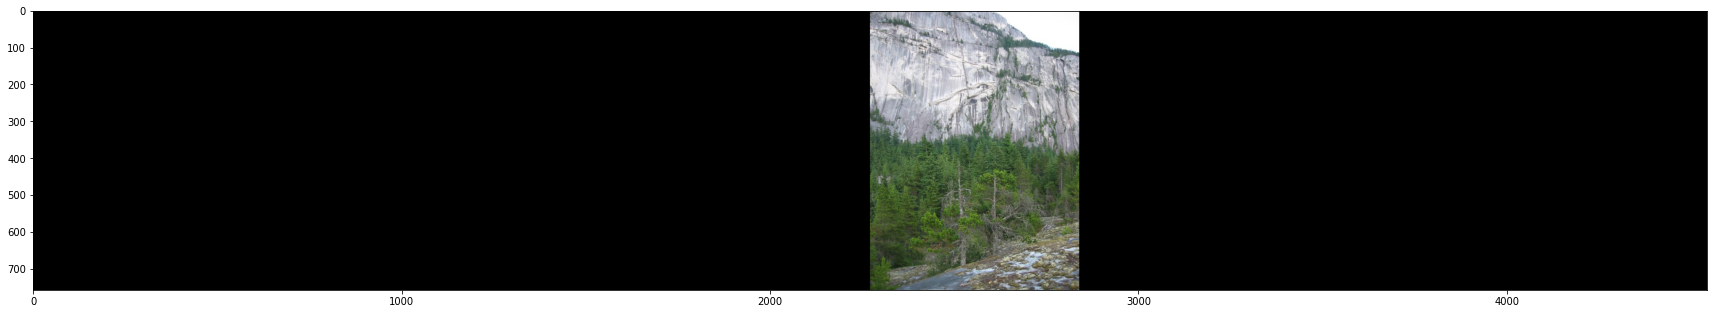

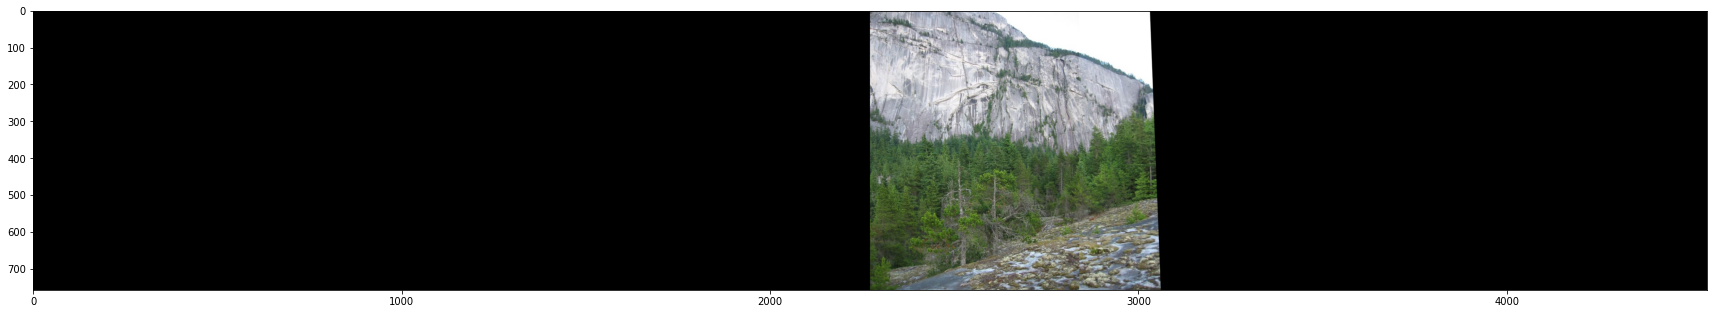

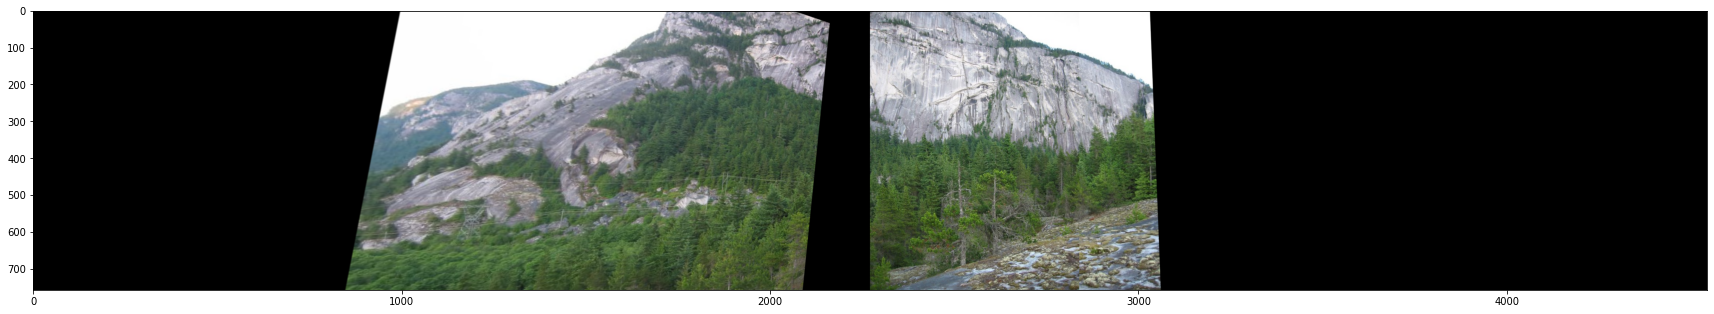

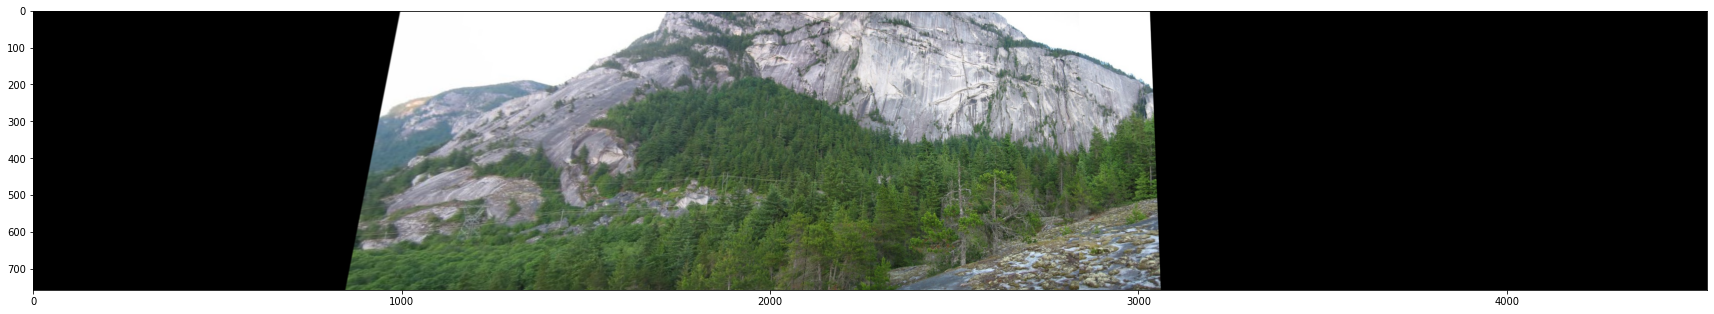

In [109]:
featureList, featureNum, HList, maskList = image_registration(apply_lm=False)
stitch_images();

steps: 136
lr: 5.803831754758099e-07
steps: 106
lr: 6.339730921683032e-07
steps: 377
lr: 9.5367431640625e-07


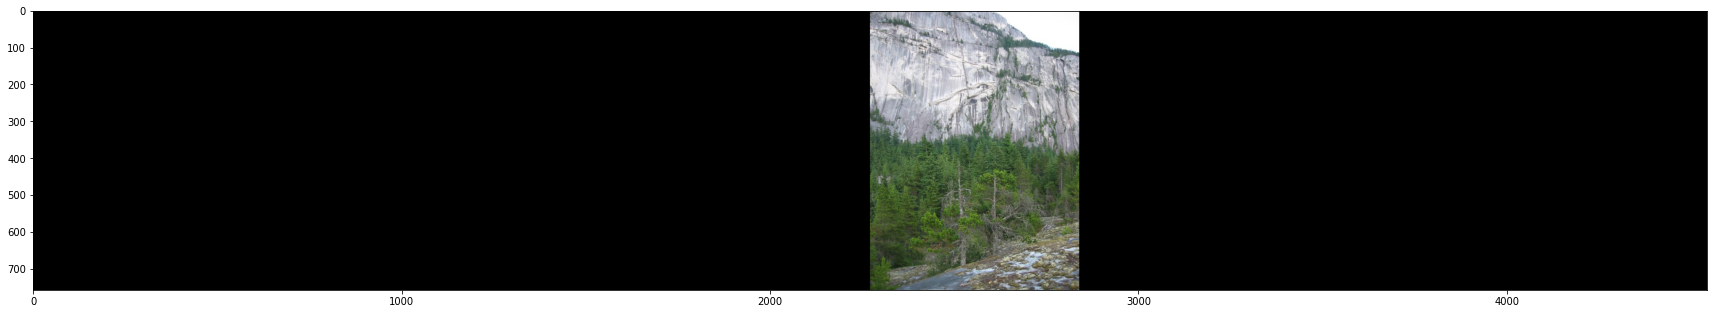

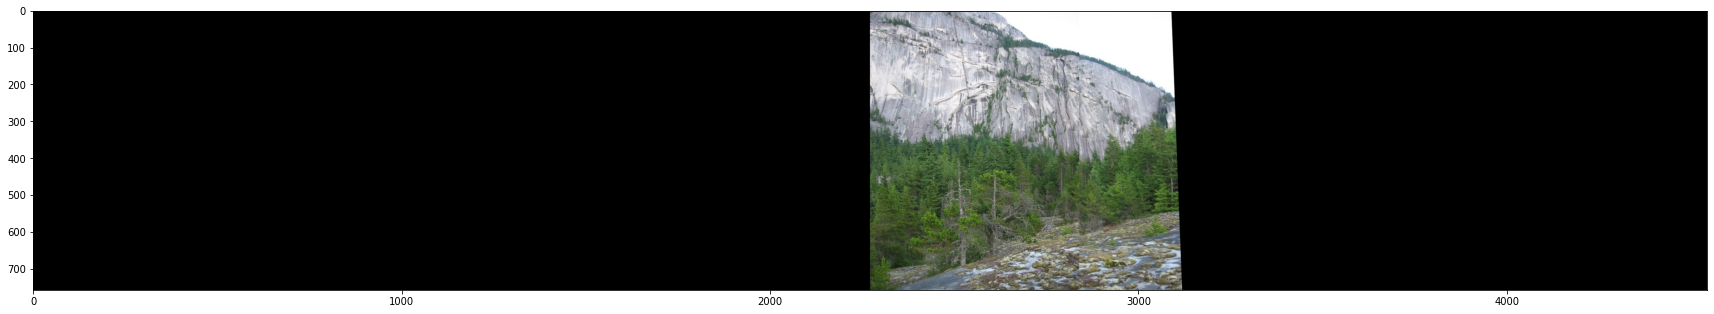

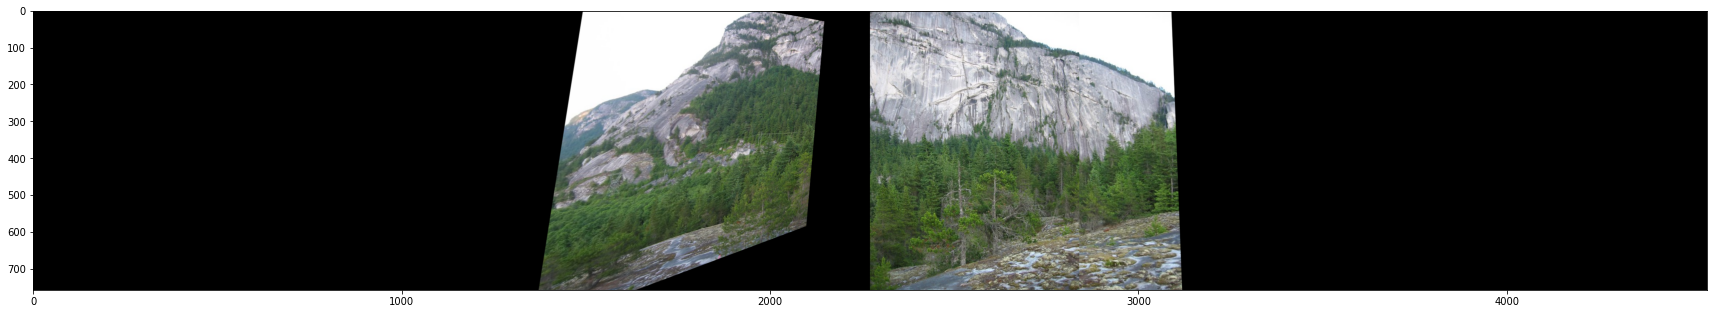

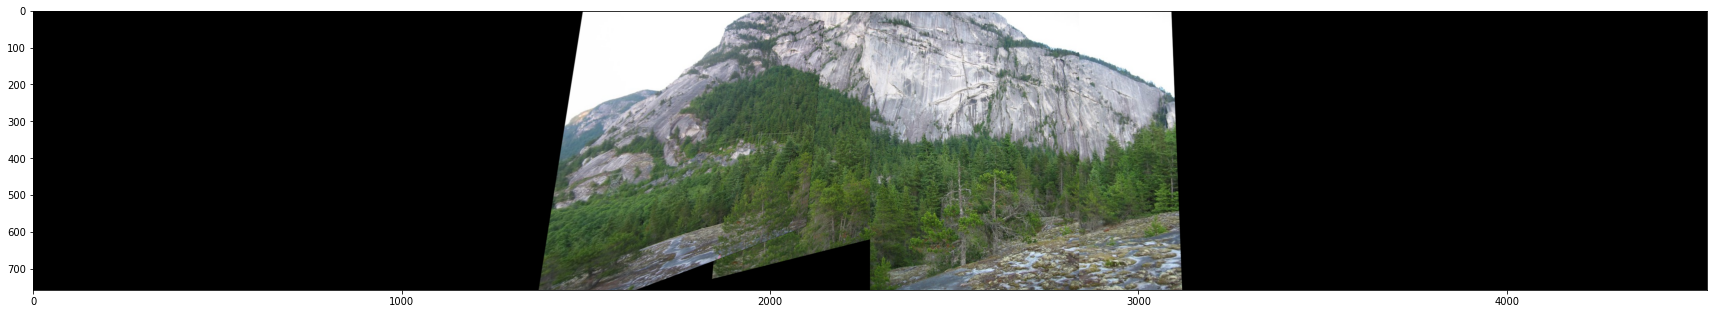

In [111]:
featureList, featureNum, HList, maskList = image_registration(apply_lm=True)
stitch_images();